<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Исследование-моделей-прогнозирования" data-toc-modified-id="Исследование-моделей-прогнозирования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследование моделей прогнозирования</a></span><ul class="toc-item"><li><span><a href="#Прогнозирование-с-использованием-модели-ARIMA" data-toc-modified-id="Прогнозирование-с-использованием-модели-ARIMA-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Прогнозирование с использованием модели ARIMA</a></span></li><li><span><a href="#Прогнозирование-с-использованием-модели-FBProphet" data-toc-modified-id="Прогнозирование-с-использованием-модели-FBProphet-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Прогнозирование с использованием модели FBProphet</a></span></li><li><span><a href="#Прогнозирование-с-использованием-градиентного-бустинга" data-toc-modified-id="Прогнозирование-с-использованием-градиентного-бустинга-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Прогнозирование с использованием градиентного бустинга</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование-оптимальной-модели" data-toc-modified-id="Тестирование-оптимальной-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование оптимальной модели</a></span></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общие выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
import os
import optuna
import sklearn.preprocessing as pr_ng
import statsmodels.api as sm
import xgboost as xgb
import category_encoders as ce
import requests

from etna.datasets.tsdataset import TSDataset
from etna.analysis import acf_plot, plot_forecast
from etna.metrics import RMSE
from etna.models import ProphetModel
from etna.transforms import MeanTransform, DateFlagsTransform
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from scipy import stats as st
from sqlalchemy import create_engine
from optuna.samplers import TPESampler
from optuna import TrialPruned
from optuna.pruners import ThresholdPruner, SuccessiveHalvingPruner
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 73

In [3]:
pth1 = './data/taxi.csv'
pth2 = None

if os.path.exists(pth1):
    df_raw = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif requests.get(pth2).status_code == 200:
    df_raw = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Что-то не так!')

display(df_raw.head())
df_raw.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
print('Проверка монотонности ряда, отсортированного по возрастанию', df_raw.index.is_monotonic_increasing)
df_resample_H = df_raw.resample('1H').sum()

Проверка монотонности ряда, отсортированного по возрастанию True


In [5]:
layout = go.Layout(
    title='Линейный график исторических данных о заказах такси в аэропортах',
    xaxis=dict(title='Дата и время заказа'),
    yaxis=dict(title='Число заказов'))
fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(x=df_resample_H.index, y=df_resample_H['num_orders'], name='Исходные данные'))
fig.add_trace(go.Scatter(
    x=df_resample_H.rolling(window=24, closed='left').mean().index, 
    y=df_resample_H.rolling(window=24, closed='left').mean()['num_orders'], 
    name='Скользящее среднее'
))
fig.add_trace(go.Scatter(
    x=df_resample_H.rolling(window=24, closed='left').mean().index, 
    y=df_resample_H.rolling(window=24, closed='left').std()['num_orders'], 
    name='Скользящее стандартное отклонение'
))
fig.show()

## Анализ

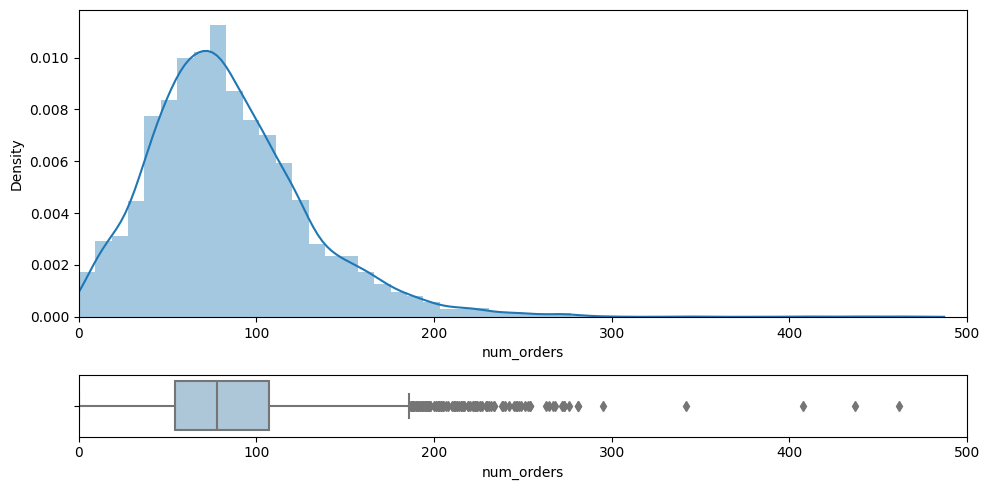

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.42,45.02,0.0,54.0,78.0,107.0,462.0


Среднее усеченное: 80.8
Стандартное отклонение на основе усеченной средней: 41.3


In [6]:
def trimmed_std_(data, percentile):
    '''
    Величина стандартного отклонения на основе усечённой средней
    '''
    data = np.array(data)
    data.sort()
    percentile = percentile / 2.
    low = int(percentile * len(data))
    high = int((1. - percentile) * len(data))
    return data[low:high].std(ddof=0)

# Озновные статистики числовых признаков
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1]) 

ax0 = plt.subplot(gs[0]) # График distplot
sns.distplot(df_resample_H['num_orders'], ax=ax0)

ax1 = plt.subplot(gs[1]) # Горизонтальный boxplot
sns.boxplot(x=df_resample_H['num_orders'], ax=ax1, orient='h', color='#A5C8E1')

ax0.set_xlim([0, 500])
ax1.set_xlim([0, 500])
plt.tight_layout()
plt.show()

display(df_resample_H.describe().round(2).transpose())
print('Среднее усеченное:', st.trim_mean(df_resample_H['num_orders'], 0.1).round(1))
print('Стандартное отклонение на основе усеченной средней:', trimmed_std_(df_resample_H, 0.1).round(1))

<p style="text-indent: 40px;">
Оценка центрального положения выборки показывает, что среднее значением 84,2 заметно больше медианного 78. Снизив влияние выбросов, рассчитав среднее усечённое значение, получаем смещение рассчитанного значения среднего заметно ближе к медианному. Оценка вариабельности выборки показывает заметное отличие размаха диапазона значений хвостов выборки 25%-min=54 и max-75%=355 что свидетельствует о правосторонней асимметрии наблюдаемого распределения. Размах выборки в 8,7 раза больше интерквантильного размаха, что говорит о наличии значительных выбросов, однако стандартное отклонение значительно меньше среднего значения, что говорит о том, что в среднем разброс значений выборки довольно умеренный, а расчёт стандартного отклонения по усечённой средней не сильно отличается от исходного значения. 

Небольшая корректировка по выбросам, доля которых составляет 3,3%, поможет улучшить качество исследуемых данных.
</p>

In [7]:
layout = go.Layout(
    title='Линейный график тренд и сезонной составляющей данных о заказах такси в аэропортах',
    xaxis=dict(title='Дата и время заказа'),
    yaxis=dict(title='Число заказов'))
fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(y=seasonal_decompose(df_resample_H).trend, mode='lines', name='Тренд'))
fig.add_trace(go.Scatter(y=seasonal_decompose(df_resample_H).seasonal, mode='lines', name='Сезонная составляющая'))
fig.add_trace(go.Scatter(y=seasonal_decompose(df_resample_H).resid, mode='lines', name='Остаток декомпозиции'))
fig.show()

Функция для проведения теста ADF (Augmented Dickey Fuller):
- Нулевая гипотеза: ряд имеет единичный корень (ряд нестационарен).
- Альтернативная гипотеза: ряд не имеет единичного корня (ряд является стационарным).

Если p-значение меньше выбранного уровня значимости, нулевая гипотеза отвергается.

In [8]:
def adf_test(timeseries):
    print('Проведение теста ADF (тест Дики-Фуллера):')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['t-stat', 'p-val', 'Tegs', 'Количество наблюдений'])
    for key, value in dftest[4].items():
        dfoutput['Критическое значение (%s)' % key] = value
    print(dfoutput.round(3))
    
adf_test(df_resample_H['num_orders'])

Проведение теста ADF (тест Дики-Фуллера):
t-stat                          -3.069
p-val                            0.029
Tegs                            30.000
Количество наблюдений         4385.000
Критическое значение (1%)       -3.432
Критическое значение (5%)       -2.862
Критическое значение (10%)      -2.567
dtype: float64


Функция для проведения теста KPSS (Kwiatkowski-Phillips-Schmidt-Shin):
- Нулевая гипотеза: ряд является стационарным.
- Альтернативная гипотеза: ряд имеет единичный корень (ряд не является стационарным).

Если p-значение меньше выбранного уровня значимости, нулевая гипотеза отвергается.

In [9]:
def kpss_test(timeseries):
    print('Проведение теста KPSS:')
    kpsstest = kpss(timeseries, regression='c', nlags='auto')
    kpss_output = pd.Series(kpsstest[0:3], index=['t-stat', 'p-val', 'Tegs'])
    for key, value in kpsstest[3].items():
        kpss_output['Критическое значение (%s)' % key] = value
    print(kpss_output.round(3))
    
kpss_test(df_resample_H['num_orders'])

Проведение теста KPSS:
t-stat                         10.913
p-val                           0.010
Tegs                           32.000
Критическое значение (10%)      0.347
Критическое значение (5%)       0.463
Критическое значение (2.5%)     0.574
Критическое значение (1%)       0.739
dtype: float64


Проведение теста ADF показало, что t-stat<t-crit при p=0.05 и t-stat>t-crit при p=0.01, следовательно ряд стационарен при p=0.05, однако нестационарен при p=0.01

Проведение теста KPSS показало, что ряд имеет единичный корень, следовательно ряд не является стационарным при p<0.01.

Анализируя тренды и сезонность можно прийти к следующим заключениям. Общий тренд идёт на увеличение количества заказов в час, можно сделать вывод на основе тестов ADF (нулевая гипотеза о не стационарности временного ряда подтверждается при p=0.01) и KPSS (нулевая гипотеза отвергается при p=0.01 и принимается альтернативная гипотеза о не стационарности временного ряда), что ряд всё же не стационарный, хотя и очень схож с таковым. Сезонная составляющая явно имеет суточную природу. Если Выполнить ресемплинг до одного дня, то колебание в тренде практически исчезают, а сезонность становится практически не отличимой от остатков декомпозиции.

Рассматриваемы временной ряд имеет выраженную суточную сезонность. Минимум заказов такси приходится на временной промежуток 5-7, и напротив пики заказов такси приходится на полночь. Интенсивный спад числа заказов наблюдается в период с полночи до раннего утра. Можно предположить, что наблюдаемая динамика связана с режимом работы городского транспорта, осуществляющего рейсы в аэропорты и небольшой популярностью ночных перелётов у потенциальных пассажиров.

In [10]:
# Применение диф-ния и лог-ния для создания стационарного ряда
df_diff = np.log1p(df_resample_H).diff().fillna(method='bfill')
df_diff.head()

,num_orders
datetime,
2018-03-01 00:00:00,-0.373966
2018-03-01 01:00:00,-0.373966
2018-03-01 02:00:00,-0.177681
2018-03-01 03:00:00,-0.071973
2018-03-01 04:00:00,-0.420503


In [11]:
adf_test(df_diff['num_orders'])

Проведение теста ADF (тест Дики-Фуллера):
t-stat                         -16.547
p-val                            0.000
Tegs                            29.000
Количество наблюдений         4386.000
Критическое значение (1%)       -3.432
Критическое значение (5%)       -2.862
Критическое значение (10%)      -2.567
dtype: float64


In [12]:
kpss_test(df_diff['num_orders'])

Проведение теста KPSS:
t-stat                           0.079
p-val                            0.100
Tegs                           205.000
Критическое значение (10%)       0.347
Критическое значение (5%)        0.463
Критическое значение (2.5%)      0.574
Критическое значение (1%)        0.739
dtype: float64


Полученные значения тестов ADF и KPSS при уровнях значимости р=0.01 и p=0.1, показывает, что выполненные преобразования значимо трансформировали нестационарный ряд приведя его к стационарному типу.

In [13]:
layout = go.Layout(
    title='График скользящего среднего значения по историческим данным о заказах такси в аэропортах',
    xaxis=dict(title='Дата и время заказа'),
    yaxis=dict(title='Число заказов'))
fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(
    x=df_resample_H.rolling(window=24, closed='left').mean().index, 
    y=df_resample_H.rolling(window=24, closed='left').mean()['num_orders'], 
    name='Исходные данные'
))
fig.add_trace(go.Scatter(
    x=df_diff.rolling(window=24, closed='left').mean().index, 
    y=df_diff.rolling(window=24, closed='left').mean()['num_orders'], 
    name='Диф-ние и лог-ние данных'
))
fig.show()

In [14]:
layout = go.Layout(
    title='График скользящего стандартного отклонения по историческим данным о заказах такси в аэропортах',
    xaxis=dict(title='Дата и время заказа'),
    yaxis=dict(title='Число заказов'))
fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(
    x=df_resample_H.rolling(window=24, closed='left').std().index, 
    y=df_resample_H.rolling(window=24, closed='left').std()['num_orders'], 
    name='Исходные данные'
))
fig.add_trace(go.Scatter(
    x=df_diff.rolling(window=24, closed='left').std().index, 
    y=df_diff.rolling(window=24, closed='left').std()['num_orders'], 
    name='Диф-ние и лог-ние данных'
))
fig.show()

In [15]:
# Подготовка данных для анализа в библиотеке etna
tsd_diff = pd.DataFrame({
    'timestamp': df_diff.index, 
    'target': df_diff.num_orders, 
    'segment': ['diff']*len(df_diff)
})
tsd = pd.DataFrame({
    'timestamp': df_resample_H.index, 
    'target': df_resample_H.num_orders, 
    'segment': ['raw']*len(df_resample_H)
})
tsd = pd.concat([tsd, tsd_diff])
tsd.reset_index(inplace=True, drop=True)
tsd = TSDataset(TSDataset.to_dataset(tsd), freq="H")
tsd.head(5)

segment,diff,raw
feature,target,target
timestamp,,
2018-03-01 00:00:00,-0.373966,124.0
2018-03-01 01:00:00,-0.373966,85.0
2018-03-01 02:00:00,-0.177681,71.0
2018-03-01 03:00:00,-0.071973,66.0
2018-03-01 04:00:00,-0.420503,43.0


In [16]:
# Графики автокорреляций
CALCULATION_OF_GRAPH = False
if CALCULATION_OF_GRAPH:
    acf_plot(ts=tsd, lags=72, columns_num=2)

[![imag](https://sun9-79.userapi.com/impg/11pFvLpRnRWRN_ivyTMA38dE70jNkdG0OloY9w/gPml3Q2NKiQ.jpg?size=2073x560&quality=95&sign=1aad7c6960c3bc4edb6523069d63fc93&type=album)]()

Дифференцирование и логарифмирование выборки помогло избавится от временной зависимости и значительно снизить влияние тренда и сезонности. Остаётся лишь слабовыраженная суточная зависимость.

## Исследование моделей прогнозирования

In [17]:
train, test = train_test_split(df_resample_H, test_size=0.1, shuffle=False)

print(f'От {train.index.min()} до {train.index.max()}, в количестве {len(train)}')
print(f'От {test.index.min()} до {test.index.max()}, в количестве {len(test)}')

От 2018-03-01 00:00:00 до 2018-08-13 13:00:00, в количестве 3974
От 2018-08-13 14:00:00 до 2018-08-31 23:00:00, в количестве 442


### Прогнозирование с использованием модели ARIMA

In [18]:
# Подбор оптимальных гиперпараметров для ARIMA
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):

        order = (
            trial.suggest_int('p', 0, 31),
            trial.suggest_int('d', 1, 15),
            trial.suggest_int('q', 0, 31)
            )
        # Создание признаков
        train_make_feat = train.copy()
        if trial.suggest_categorical('day', [True,False]):
            train_make_feat['day'] = train_make_feat.index.day
        if trial.suggest_categorical('dayofweek', [True,False]):
            train_make_feat['dayofweek'] = train_make_feat.index.dayofweek
        if trial.suggest_categorical('lag_n', [True,False]):
            for lag in range(1, trial.suggest_int('max_lag', 1, 24) + 1):
                train_make_feat['lag_{}'.format(lag)] = train_make_feat['num_orders'].shift(lag)
        if trial.suggest_categorical('rolling_mean', [True,False]):
            train_make_feat['rolling_mean'] = train_make_feat['num_orders'] \
                .shift().rolling(trial.suggest_int('rolling_mean_size', 1, 24)).mean()
        train_make_feat.dropna(inplace=True)

        try:
            scores = [] # Получене целевых метрик на кросвалидации
            for train_index, test_index in TimeSeriesSplit(n_splits=9).split(train_make_feat):
                train_fold, test_fold = train_make_feat.iloc[train_index], train_make_feat.iloc[test_index]

                exog_train_fold = train_fold[list(set(train_make_feat.columns) - set(['num_orders']))]
                exog_test_fold = test_fold[list(set(train_make_feat.columns) - set(['num_orders']))]

                model = ARIMA(train_fold['num_orders'], order=order, exog=exog_train_fold)
                predictions = model.fit().predict(
                    start=len(train_fold), 
                    end=len(train_fold) + len(test_fold) - 1, 
                    exog=exog_test_fold
                )
                scores.append(np.sqrt(mean_squared_error(test_fold['num_orders'], predictions)))

            return np.mean(scores)
        except:
            raise optuna.TrialPruned()

    study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=RANDOM_STATE),
        pruner=SuccessiveHalvingPruner(),
        )
    study.optimize(objective, n_trials=100, timeout=None, n_jobs=6)
else:
    print('''
Количество завершенных испытаний: 200
Лучшее испытание завершено на итерации: 174
Лучшее значение целевой метрики: 31.87537813711602
''')
    # Создание признаков
    train_make_feat = train.copy()

    scores = [] # Получене целевых метрик на кросвалидации
    for train_index, test_index in TimeSeriesSplit(n_splits=9).split(train_make_feat):
        train_fold, test_fold = train_make_feat.iloc[train_index], train_make_feat.iloc[test_index]

        model = ARIMA(train_fold['num_orders'], order=(32,1,12))
        predictions = model.fit().predict(
            start=len(train_fold), 
            end=len(train_fold) + len(test_fold) - 1
        )
        scores.append(np.sqrt(mean_squared_error(test_fold['num_orders'], predictions)))

    print('Значение RMSE:', np.mean(scores).round(1))
    print('95% доверительный интервал:', np.round(st.t.interval(
        confidence=0.95, 
        df=(len(scores) - 1), 
        loc=np.mean(scores), 
        scale=np.std(scores)
    ),1))

    fig = go.Figure()
    fig.add_trace(go.Scatter(y=test_fold.num_orders, name='Исходные значения'))
    fig.add_trace(go.Scatter(y=predictions, name='Предсказанные значения'))
    fig.update_layout(
        xaxis_title='Дата и время заказа', 
        yaxis_title='Число заказов', 
        title='График прогноза заказов такси')
    fig.show()


Количество завершенных испытаний: 200
Лучшее испытание завершено на итерации: 174
Лучшее значение целевой метрики: 31.87537813711602

Значение RMSE: 31.4
95% доверительный интервал: [21.9 41. ]


### Прогнозирование с использованием модели FBProphet

In [19]:
def TSDatasetSplit_(data):
    '''
    Подготовка данных для анализа в библиотеке etna
    '''
    tsd = pd.DataFrame({'timestamp': data.index, 'target': data.num_orders, 'segment': ['raw']*len(data)})
    tsd.reset_index(inplace=True, drop=True)
    tsd = TSDataset(TSDataset.to_dataset(tsd), freq='H')
    return tsd


Количество завершенных испытаний: 1000
Лучшее испытание завершено на итерации: 901
Лучшее значение целевой метрики: 32.53956008685877



14:45:25 - cmdstanpy - INFO - Chain [1] start processing
14:45:25 - cmdstanpy - INFO - Chain [1] done processing
14:45:25 - cmdstanpy - INFO - Chain [1] start processing
14:45:26 - cmdstanpy - INFO - Chain [1] done processing
14:45:26 - cmdstanpy - INFO - Chain [1] start processing
14:45:26 - cmdstanpy - INFO - Chain [1] done processing
14:45:27 - cmdstanpy - INFO - Chain [1] start processing
14:45:27 - cmdstanpy - INFO - Chain [1] done processing
14:45:27 - cmdstanpy - INFO - Chain [1] start processing
14:45:27 - cmdstanpy - INFO - Chain [1] done processing
14:45:28 - cmdstanpy - INFO - Chain [1] start processing
14:45:28 - cmdstanpy - INFO - Chain [1] done processing
14:45:28 - cmdstanpy - INFO - Chain [1] start processing
14:45:29 - cmdstanpy - INFO - Chain [1] done processing
14:45:29 - cmdstanpy - INFO - Chain [1] start processing
14:45:30 - cmdstanpy - INFO - Chain [1] done processing
14:45:30 - cmdstanpy - INFO - Chain [1] start processing
14:45:31 - cmdstanpy - INFO - Chain [1]

Значение RMSE: 26.515
95% доверительный интервал: [18.638 34.392]


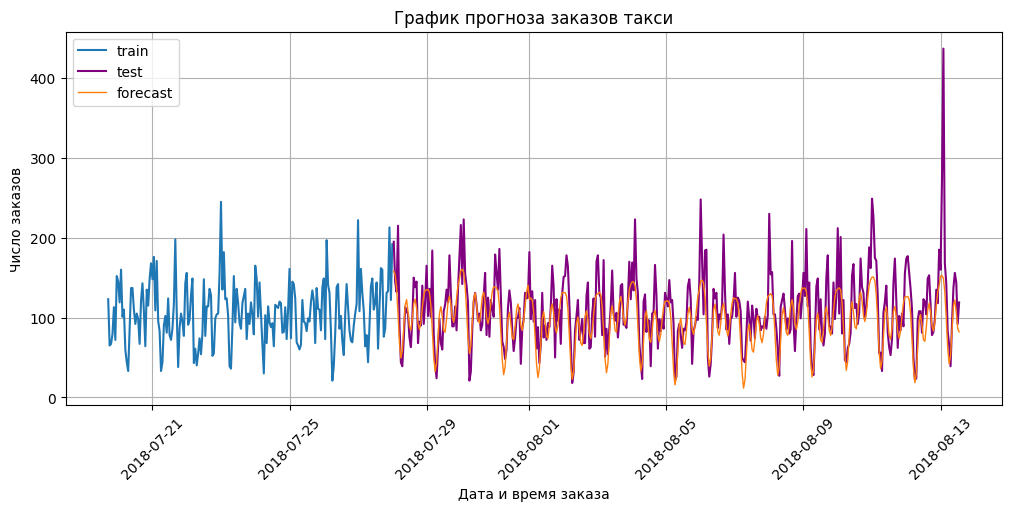

In [20]:
# Подбор оптимальных гиперпараметров для ProphetModel
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):

        d_flags = DateFlagsTransform(
            out_column='d_flags',
            day_number_in_week=trial.suggest_categorical('day_number_in_week', [True,False]),
            day_number_in_month=trial.suggest_categorical('day_number_in_month', [True,False]),
            week_number_in_month=trial.suggest_categorical('week_number_in_month', [True,False]),
            week_number_in_year=trial.suggest_categorical('week_number_in_year', [True,False]),
            month_number_in_year=trial.suggest_categorical('month_number_in_year', [True,False]),
            special_days_in_week=[5, 6],
        )
        mean_transf = MeanTransform(
            in_column='target', 
            out_column='mean_transf',
            window=trial.suggest_int('window_mean', 1, 168),
            seasonality=trial.suggest_int('seasonality_mean', 1, 168)
        )
        transforms = [d_flags,mean_transf]

        model = ProphetModel(
            n_changepoints=trial.suggest_int('n_changepoints', 12, 720),
            changepoint_range=trial.suggest_float('changepoint_range', 0.1, 1),
            holidays_prior_scale=trial.suggest_int('holidays_prior_scale', 0, 24),
            seasonality_mode=trial.suggest_categorical('seasonality_mode', ['additive','multiplicative']),
            seasonality_prior_scale=trial.suggest_int('seasonality_prior_scale', 12, 168),
            changepoint_prior_scale=trial.suggest_float('changepoint_prior_scale', 0.001, 0.5),
            holidays=None
        )
        rmse = RMSE()

        try:
            scores = []
            for train_index, test_index in TimeSeriesSplit(n_splits=9).split(train):
                train_fold, test_fold = TSDatasetSplit_(train.iloc[train_index]), TSDatasetSplit_(train.iloc[test_index])

                train_fold.fit_transform(transforms)
                model.fit(train_fold)
                future_ts = train_fold.make_future(len(test_fold.to_pandas()))
                future_ts.fit_transform(transforms)
                forecast_tsd = model.forecast(future_ts)

                scores.append(rmse(y_true=test_fold, y_pred=forecast_tsd)['raw'])

            return st.t.interval(confidence=0.95, df=(len(scores) - 1), loc=np.mean(scores), scale=np.std(scores))[1]
        except:
            raise optuna.TrialPruned()

    study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=RANDOM_STATE),
        pruner=SuccessiveHalvingPruner(),
        #study_name='ProphetModel', storage='sqlite:///my_study_ProphetModel.db', load_if_exists=True
        )
    study.optimize(objective, n_trials=1, timeout=None, n_jobs=1)
else:
    print('''
Количество завершенных испытаний: 1000
Лучшее испытание завершено на итерации: 901
Лучшее значение целевой метрики: 32.53956008685877
''')
    d_flags = DateFlagsTransform(
        out_column='d_flags',
        week_number_in_month=True,
        special_days_in_week=[5, 6],
    )
    mean_transf = MeanTransform(
        in_column='target', 
        out_column='mean_transf',
        window=154,
        seasonality=71
    )
    transforms = [d_flags,mean_transf]

    model = ProphetModel(
        n_changepoints=21,
        changepoint_range=0.6938431237160939,
        holidays_prior_scale=12,
        seasonality_mode='multiplicative',
        seasonality_prior_scale=136,
        changepoint_prior_scale=0.23126499462038597,
        holidays=None
    )
    rmse = RMSE()

    scores = []
    for train_index, test_index in TimeSeriesSplit(n_splits=9).split(train):
        train_fold, test_fold = TSDatasetSplit_(train.iloc[train_index]), TSDatasetSplit_(train.iloc[test_index])

        train_fold.fit_transform(transforms)
        model.fit(train_fold)
        future_ts = train_fold.make_future(len(test_fold.to_pandas()))
        future_ts.fit_transform(transforms)
        forecast_tsd = model.forecast(future_ts)

        scores.append(rmse(y_true=test_fold, y_pred=forecast_tsd)['raw'])

    print('Значение RMSE:', np.mean(scores).round(3))
    print('95% доверительный интервал:', np.round(st.t.interval(
        confidence=0.95, 
        df=(len(scores) - 1), 
        loc=np.mean(scores), 
        scale=np.std(scores)
    ),3))

    plot_forecast(forecast_tsd, test_fold, train_fold, n_train_samples=200)
    plt.title('График прогноза заказов такси')
    plt.ylabel('Число заказов')
    plt.xlabel('Дата и время заказа')
    plt.show()

### Прогнозирование с использованием градиентного бустинга

In [21]:
# Список зипланированных к использованию методов
scaler_type = [
    pr_ng.StandardScaler(),
    pr_ng.MinMaxScaler(),
    pr_ng.RobustScaler(),
    pr_ng.MaxAbsScaler(),
    pr_ng.Normalizer()
]
encoder_type = [
    ce.TargetEncoder(),
    ce.QuantileEncoder(),
    ce.OrdinalEncoder(),
    ce.MEstimateEncoder(),
    ce.LeaveOneOutEncoder(),
    ce.JamesSteinEncoder(),
    ce.GLMMEncoder(),
    ce.CountEncoder(),
    ce.CatBoostEncoder(),
    ce.BinaryEncoder(),
    ce.BaseNEncoder()
]

In [23]:
# Подбор оптимальных гиперпараметров для XGBRegressor
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):

        # Создание признаков
        CAT_FEATURES = []
        train_make_feat = train.copy()
        if trial.suggest_categorical('hour', [True,False]):
            train_make_feat['hour'] = train_make_feat.index.hour
            CAT_FEATURES.append('hour')
        if trial.suggest_categorical('day', [True,False]):
            train_make_feat['day'] = train_make_feat.index.day
            CAT_FEATURES.append('day')
        if trial.suggest_categorical('dayofweek', [True,False]):
            train_make_feat['dayofweek'] = train_make_feat.index.dayofweek
            CAT_FEATURES.append('dayofweek')
        if trial.suggest_categorical('month', [True,False]):
            train_make_feat['month'] = train_make_feat.index.month
            CAT_FEATURES.append('month')
        if trial.suggest_categorical('lag_n', [True]):
            for lag in range(1, trial.suggest_int('max_lag', 1, 144) + 1):
                train_make_feat['lag_{}'.format(lag)] = train_make_feat['num_orders'].shift(lag)
        if trial.suggest_categorical('rolling_mean', [True,False]):
            train_make_feat['rolling_mean'] = train_make_feat['num_orders']\
                .shift().rolling(trial.suggest_int('rolling_mean_size', 1, 144)).mean()
        train_make_feat.dropna(inplace=True)

        if not CAT_FEATURES:
            CAT_FEATURES=None
        else:
            train_make_feat[CAT_FEATURES] = train_make_feat[CAT_FEATURES].astype('category')

        X_diff_cb = train_make_feat.drop(['num_orders'], axis=1)
        Y_diff_cb = train_make_feat.num_orders

        if trial.suggest_categorical('depth', [True, False]):
            max_depth=trial.suggest_int('max_depth', 10, 30)
        else:
            max_depth=None

        model = xgb.XGBRegressor(
            random_state=RANDOM_STATE,
            #tree_method='gpu_hist', predictor='gpu_predictor',
            verbosity=0,
            objective='reg:squarederror',
            max_depth=max_depth,
            learning_rate=trial.suggest_float('learning_rate', 0.0001, 0.5),
            n_estimators=trial.suggest_int('n_estimators', 10, 2000),
            booster=trial.suggest_categorical('booster', ['gbtree','gblinear']),
            gamma=trial.suggest_float('gamma', 0, 10, step=0.01),
            min_child_weight=trial.suggest_float('min_child_weight', 0, 10),
            subsample=trial.suggest_float('subsample', 0.1, 1),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.1, 1),
            colsample_bylevel=trial.suggest_float('colsample_bylevel', 0.1, 1),
            colsample_bynode=trial.suggest_float('colsample_bynode', 0.1, 1),
            reg_alpha=trial.suggest_float('reg_alpha', 0, 100),
            reg_lambda=trial.suggest_float('reg_lambda', 0, 100),
            base_score=0.5,
            )
        num_pipe = Pipeline([(
            'scaler', scaler_type[trial.suggest_categorical('scaler', [0,1,2,3,4])]
        )])
        column_transf = ColumnTransformer(transformers=[(
            'encoder', encoder_type[trial.suggest_categorical('encoder', [0,1,2,3,4,5,6,7,8,9,10])], CAT_FEATURES
        )], remainder='passthrough')
        pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', model)])
        
        try:
            scores = []
            for train_index, test_index in TimeSeriesSplit(n_splits=9).split(X_diff_cb):
                X_train_fold = pd.DataFrame(X_diff_cb.iloc[train_index], columns=X_diff_cb.columns)
                Y_train_fold = Y_diff_cb.iloc[train_index]
                X_test_fold = pd.DataFrame(X_diff_cb.iloc[test_index], columns=X_diff_cb.columns)
                Y_test_fold = Y_diff_cb.iloc[test_index]

                pipeline.fit(X_train_fold, Y_train_fold)
                pred = pipeline.predict(X_test_fold)

                scores.append(mean_squared_error(Y_test_fold, pred) ** 0.5)

            return st.t.interval(confidence=0.95, df=(len(scores) - 1), loc=np.mean(scores), scale=np.std(scores))[1]
        except:
            raise optuna.TrialPruned()

    study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=RANDOM_STATE),
        pruner=SuccessiveHalvingPruner(),
        study_name='XGBRegressor', storage='sqlite:///my_study_XGBRegressor.db', load_if_exists=True
        )
    study.optimize(objective, n_trials=1, timeout=None, n_jobs=4)
else:
    print('''
Количество завершенных испытаний: 1000
Лучшее испытание завершено на итерации: 534
Лучшее значение целевой метрики: 33.440265539104346
''')
    train_make_feat = train.copy()
    train_make_feat['dayofweek'] = train_make_feat.index.dayofweek
    for lag in range(1, 104 + 1):
        train_make_feat['lag_{}'.format(lag)] = train_make_feat['num_orders'].shift(lag)
    train_make_feat.dropna(inplace=True)

    CAT_FEATURES = ['dayofweek']
    train_make_feat[CAT_FEATURES] = train_make_feat[CAT_FEATURES].astype('category')

    X_diff_cb = train_make_feat.drop(['num_orders'], axis=1)
    Y_diff_cb = train_make_feat.num_orders

    model = xgb.XGBRegressor(
        random_state=RANDOM_STATE,
        #tree_method='gpu_hist', predictor='gpu_predictor',
        verbosity=0,
        objective='reg:squarederror',
        max_depth=None,
        learning_rate=0.20528697502919102,
        n_estimators=827,
        booster='gbtree',
        gamma=8.45,
        min_child_weight=4.489367238915258,
        subsample=0.33875315678895335,
        colsample_bytree=0.2030416746567203,
        colsample_bylevel=0.23008489248342398,
        colsample_bynode=0.5489665243869036,
        reg_alpha=8.563195093309632,
        reg_lambda=25.43289730862925,
        base_score=0.5,
        )
    num_pipe = Pipeline([('scaler', pr_ng.RobustScaler())])
    column_transf = ColumnTransformer(transformers=[('encoder', ce.BinaryEncoder(), CAT_FEATURES)], remainder='passthrough')
    pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', model)])
    
    scores = []
    for train_index, test_index in TimeSeriesSplit(n_splits=9).split(X_diff_cb):
        X_train_fold = pd.DataFrame(X_diff_cb.iloc[train_index], columns=X_diff_cb.columns) 
        Y_train_fold = Y_diff_cb.iloc[train_index]
        X_test_fold = pd.DataFrame(X_diff_cb.iloc[test_index], columns=X_diff_cb.columns)
        Y_test_fold = Y_diff_cb.iloc[test_index]

        pipeline.fit(X_train_fold, Y_train_fold)
        pred = pipeline.predict(X_test_fold)
        scores.append(mean_squared_error(Y_test_fold, pred) ** 0.5)

    print('Значение RMSE:', np.mean(scores).round(1))
    print('95% доверительный интервал:', np.round(st.t.interval(
        confidence=0.95, 
        df=(len(scores) - 1), 
        loc=np.mean(scores), 
        scale=np.std(scores)
    ),1))

    fig = go.Figure()
    fig.add_trace(go.Scatter(y=Y_test_fold, name='Исходные значения'))
    fig.add_trace(go.Scatter(y=pred, name='Предсказанные значения'))
    fig.update_layout(
        xaxis_title='Дата и время заказа', 
        yaxis_title='Число заказов', 
        title='График прогноза заказов такси')
    fig.show()


Количество завершенных испытаний: 1000
Лучшее испытание завершено на итерации: 534
Лучшее значение целевой метрики: 33.440265539104346

Значение RMSE: 24.8
95% доверительный интервал: [16.9 32.7]


### Вывод

Лучшие результаты на валидации показывает ProphetModel со значением RMSE=26.3 и 95% доверительным интервалом 19.9-32.6. Модель довольно хорошо распознала тренд и сезонность, а также минимальные пики, однако не видит множественные максимальные пики, что, вероятно, можно исправить дополнительными признаками на основе максимальных и минимальных значений. Схожие результаты по качеству так же показал градиентный бустинг RMSE=25.0, модель очень хорошо подстраивается под тренд и сезонность, но при этом хуже себя показывает на новых данных, демонстрируя заметно большую дисперсию на валидации 95% доверительный интервал 16.6-33.4.

Слабые результаты показала модель ARIMA, RMSE=31.9 и 95% доверительным интервалом 19.9-32.6. Ещё более худшие результаты получились с дифференцированием и логарифмированием таргета в ProphetModel. С дифференцированием и логарифмированием таргета для градиентного бустинга и вовсе строится практически константа, по какой причине, понять не получилось.

## Тестирование оптимальной модели

12:58:21 - cmdstanpy - INFO - Chain [1] start processing
12:58:21 - cmdstanpy - INFO - Chain [1] done processing


Значение RMSE: 43.0


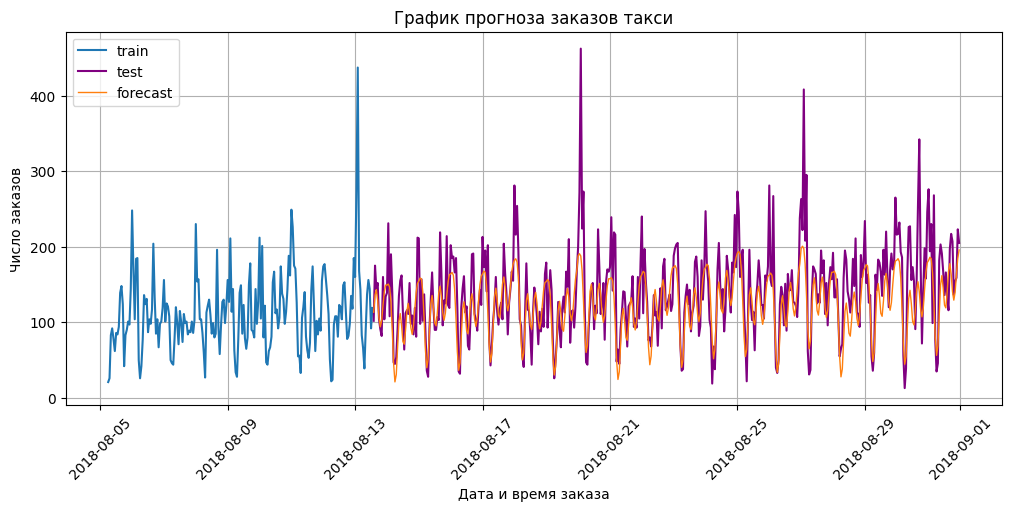

In [24]:
d_flags = DateFlagsTransform(
    out_column='d_flags',
    week_number_in_month=True,
    special_days_in_week=[5, 6],
)
mean_transf = MeanTransform(
    in_column='target', 
    out_column='mean_transf',
    window=154,
    seasonality=71
)
transforms = [d_flags,mean_transf]

model = ProphetModel(
    n_changepoints=21,
    changepoint_range=0.6938431237160939,
    holidays_prior_scale=12,
    seasonality_mode='multiplicative',
    seasonality_prior_scale=136,
    changepoint_prior_scale=0.23126499462038597,
    holidays=None
)
train_ts, test_ts = TSDatasetSplit_(train), TSDatasetSplit_(test)
train_ts.fit_transform(transforms)
model.fit(train_ts)
future_ts = train_ts.make_future(len(test))
future_ts.fit_transform(transforms)
forecast_tsd = model.forecast(future_ts)

plot_forecast(forecast_tsd, test_ts, train_ts, n_train_samples=200)
print('Значение RMSE:', np.round(RMSE()(y_true=test_ts, y_pred=forecast_tsd)['raw'],1))
plt.title('График прогноза заказов такси')
plt.ylabel('Число заказов')
plt.xlabel('Дата и время заказа')
plt.show()

In [25]:
print('Среднее количество заказов такси:', df_resample_H['num_orders'].mean())

pred_median = np.ones(test.shape) * train['num_orders'].median()
print('RMSE:', np.sqrt(mean_squared_error(test, pred_median)))

pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('RMSE:', np.sqrt(mean_squared_error(test, pred_previous)))

Среднее количество заказов такси: 84.42278079710145
RMSE: 87.15277582981295
RMSE: 58.856486242815066


Получена целевая метрика на тестовых данных RMSE=43 ниже установленного предела (48). Построенную модель можно назвать адекватной, поскольку целевая метрика модели показывает более качественные результаты, чем метрики полученные на основе константы или смещённой выборки.

## Общие выводы

- **Анализ данных.** Оценка центрального положения выборки показывает, что среднее значением 84,2 заметно больше медианного 78. Оценка вариабельности выборки свидетельствует о правосторонней асимметрии наблюдаемого распределения. В данных отмечено наличии значительных выбросов, однако разброс значений выборки довольно умеренный. Анализируя тренды и сезонность видно, что общий тренд идёт на увеличение количества заказов в час, можно сделать вывод на основе тестов ADF и KPSS, что ряд всё же не стационарный, хотя и очень схож с таковым. Сезонная составляющая явно имеет суточную природу.

- **Исследование моделей.** Лучшие результаты на валидации показывает ProphetModel со значением RMSE=26.3 и 95% доверительным интервалом 19.9-32.6. Модель довольно хорошо распознала тренд и сезонность, а также минимальные пики, однако не видит множественные максимальные пики, что, вероятно, можно исправить дополнительными признаками на основе максимальных и минимальных значений. Схожие результаты по качеству так же показал градиентный бустинг RMSE=25.0, модель очень хорошо подстраивается под тренд и сезонность, но при этом хуже себя показывает на новых данных, демонстрируя заметно большую дисперсию на валидации 95% доверительный интервал 16.6-33.4. Дифференцирование и логарифмирование выборки не помогло построить модели с более сильной целевой метрикой.

- **Тестирование оптимальной модели.** Тестировалась модель на основе ProphetModel. Получена целевая метрика на тестовых данных RMSE=43 ниже установленного предела (48). Построенную модель можно назвать адекватной, поскольку целевая метрика модели показывает более качественные результаты, чем метрики полученные на основе константы или смещённой выборки.